In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests
from tqdm.notebook import tqdm_notebook
import warnings
import time
from requests import get
warnings.filterwarnings("ignore")
import nltk


from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPRegressor, BernoulliRBM


In [2]:
seinfeld = pd.read_csv('seinfeld_episode_rankings.csv')

In [3]:
seinfeld

,Title,Plot,Quotability/cultural impact,Laughs,Total score,IMDb rating,IMDb rank,Notes,Season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
seinfeld.columns=['title','plot','quotability','laughs','total_score','imdb_rating','imdb_rank','notes','season','episode']

In [5]:
#seinfeld=seinfeld[seinfeld.season<7]

In [6]:
seinfeld.sort_values('total_score',ascending=False)

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
77,the_marine_biologist,5.0,9.0,52.0,101.739130,9.2,5.0,NaN,5.0,14.0
112,the_soup_nazi,5.0,10.0,45.0,97.826087,9.5,3.0,NaN,7.0,6.0
83,the_hamptons,5.0,9.0,48.0,93.913043,8.9,10.0,"""Shrinkage""",5.0,20.0
103,the_fusilli_jerry,4.0,10.0,49.0,85.217391,8.7,24.0,assman,6.0,19.0
50,the_contest,5.0,10.0,31.0,67.391304,9.6,1.0,first appearance of Estelle.,4.0,11.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
scripts = pd.read_csv('seinfeld_data/scripts.csv')

In [8]:
episodes = pd.read_csv('seinfeld_data/episode_info.csv')

In [9]:
episodes = episodes.drop(columns='Unnamed: 0')

In [10]:
episodes.Title = episodes.Title.astype(str)

In [11]:
episodes.Title = episodes.Title.str.lower().str.replace(' ','_').str.replace(',','')

In [12]:
scripts = scripts.drop(columns='Unnamed: 0')

In [13]:
scripts[0:211].SEID = scripts.SEID.str.replace('S01E01','S01E00')
scripts[0:211].EpisodeNo = 0.0

In [14]:
scripts['line']=scripts.Character.str.strip() +': ' + scripts.Dialogue.str.strip()

In [15]:
episodes.SEID[0] = 'S01E00'
episodes.EpisodeNo[0] = 0.0

In [16]:
scripts

,Character,Dialogue,EpisodeNo,SEID,Season,line
0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0,JERRY: Do you know what this is all about? Do ...
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0,"JERRY: (pointing at Georges shirt) See, to me,..."
2,GEORGE,Are you through?,1.0,S01E01,1.0,GEORGE: Are you through?
3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0,"JERRY: You do of course try on, when you buy?"
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0,"GEORGE: Yes, it was purple, I liked it, I dont..."
...,...,...,...,...,...,...
54611,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,S09E23,9.0,JERRY: Grand theft auto - don't steal any of m...
54612,PRISONER 3,You suck - I'm gonna cut you.,23.0,S09E23,9.0,PRISONER 3: You suck - I'm gonna cut you.
54613,JERRY,"Hey, I don't come down to where you work, and ...",23.0,S09E23,9.0,"JERRY: Hey, I don't come down to where you wor..."
54614,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,S09E23,9.0,"GUARD: Alright, Seinfeld, that's it. Let's go...."


In [17]:
scripts.Character=scripts.Character.str.replace(r"\(.*\)","")

In [18]:
line_count=scripts.Character.value_counts().head(475)

In [19]:
scripts.Character.str.strip().value_counts().head(10)

JERRY       14905
GEORGE       9781
ELAINE       8073
KRAMER       6723
NEWMAN        649
MORTY         507
HELEN         474
FRANK         438
SUSAN         382
[Setting      293
Name: Character, dtype: int64

In [20]:
episodes["SEID"] = episodes.SEID.astype(str)
scripts["SEID"] = scripts.SEID.astype(str)

In [21]:
pd.merge(episodes, right=scripts, on='SEID')

,Season_x,EpisodeNo_x,Title,AirDate,Writers,Director,SEID,Character,Dialogue,EpisodeNo_y,Season_y,line
0,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,JERRY,Do you know what this is all about? Do you kno...,1.0,1.0,JERRY: Do you know what this is all about? Do ...
1,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,1.0,"JERRY: (pointing at Georges shirt) See, to me,..."
2,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,GEORGE,Are you through?,1.0,1.0,GEORGE: Are you through?
3,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,JERRY,"You do of course try on, when you buy?",1.0,1.0,"JERRY: You do of course try on, when you buy?"
4,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,1.0,"GEORGE: Yes, it was purple, I liked it, I dont..."
...,...,...,...,...,...,...,...,...,...,...,...,...
54611,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,9.0,JERRY: Grand theft auto - don't steal any of m...
54612,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,PRISONER 3,You suck - I'm gonna cut you.,23.0,9.0,PRISONER 3: You suck - I'm gonna cut you.
54613,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,JERRY,"Hey, I don't come down to where you work, and ...",23.0,9.0,"JERRY: Hey, I don't come down to where you wor..."
54614,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,9.0,"GUARD: Alright, Seinfeld, that's it. Let's go...."


In [22]:
seinfeld.title[0] = 'good_news_bad_news'

In [23]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
episodes.columns = episodes.columns.str.lower()


In [25]:
seinfeld.title = seinfeld.title.str.replace(r"\d:\d*","").str.strip().str.replace(' ','_').str.lower()

In [26]:
seinfeld[seinfeld.title=="the_cafe"]

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
23,the_cafe,4.0,6.0,9.5,9.913043,8.4,58.0,Babu’s first appearance,3.0,7.0


In [27]:
episodes[episodes.title=='the_cafe']

,season,episodeno,title,airdate,writers,director,seid
23,3.0,7.0,the_cafe,"November 6, 1991",Tom Leopold,Tom Cherones,S03E07


In [28]:
episodes.title.to_csv('titles.csv')

In [29]:
seinfeld=pd.merge(seinfeld, right = episodes, on='title')

In [30]:
seinfeld.sort_values('total_score',ascending=True).head(10)

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid
173,the_finale,NaN,NaN,NaN,0.0,7.8,158.0,NaN,9.0,21.0,9.0,23.0,"May 14, 1998",Larry David,Andy Ackerman,S09E23
137,the_checks,NaN,NaN,NaN,0.0,8.1,112.0,NaN,8.0,6.0,8.0,7.0,"November 7, 1996","Steve O'Donnell and Tom Gammill, Max Pross",Andy Ackerman,S08E07
138,the_chicken_roaster,NaN,NaN,NaN,0.0,8.9,10.0,NaN,8.0,7.0,8.0,8.0,"November 14, 1996","Alec Berg, Jeff Schaffer",Andy Ackerman,S08E08
139,the_abstinence,NaN,NaN,NaN,0.0,9.0,7.0,NaN,8.0,8.0,8.0,9.0,"November 21, 1996",Steve Koren,Andy Ackerman,S08E09
140,the_andrea_doria,NaN,NaN,NaN,0.0,8.4,58.0,NaN,8.0,9.0,8.0,10.0,"December 19, 1996",Spike Feresten,Andy Ackerman,S08E10
141,the_little_jerry,NaN,NaN,NaN,0.0,8.3,79.0,NaN,8.0,10.0,8.0,11.0,"January 9, 1997",Jennifer Crittenden,Andy Ackerman,S08E11
142,the_money,NaN,NaN,NaN,0.0,7.7,160.0,NaN,8.0,11.0,8.0,12.0,"January 16, 1997",Peter Mehlman,Andy Ackerman,S08E12
143,the_comeback,NaN,NaN,NaN,0.0,8.5,49.0,NaN,8.0,12.0,8.0,13.0,"January 30, 1997","Gregg Kavet, Andy Robin",David Owen Trainor,S08E13
144,the_van_buren_boys,NaN,NaN,NaN,0.0,8.0,135.0,NaN,8.0,13.0,8.0,14.0,"February 6, 1997",Darin Henry,Andy Ackerman,S08E14
145,the_susie,NaN,NaN,NaN,0.0,8.6,35.0,NaN,8.0,14.0,8.0,15.0,"February 13, 1997",David Mandel,Andy Ackerman,S08E15


In [31]:
seinfeld.director = seinfeld.director.replace('David&nbsp; Steinberg','David Steinberg')

In [32]:
seinfeld.director.value_counts()

Andy Ackerman         87
Tom Cherones          80
David Steinberg        2
David Owen Trainor     2
Art Wolff              1
Joshua White           1
Jason Alexander        1
Name: director, dtype: int64

In [33]:
scripts.Character = scripts.Character.str.strip()
scripts.Character = scripts.Character.replace(r'babu.*|BABU.*','BABU')

In [34]:
scripts.Character.nunique()

1214

In [35]:
scripts=scripts[~scripts.Character.str.contains(r'\(\*|[a-z]|http')]

In [36]:
#scripts = scripts.drop(index=scripts[(scripts.Character==r'http')|(scripts.Dialogue.isnull())].index.tolist())
grouped_scripts=scripts.groupby('SEID')

In [37]:
seinfeld.writers.value_counts()

Larry David                                                                                                                                              29
Larry David, Jerry Seinfeld                                                                                                                              15
Larry Charles                                                                                                                                            15
Peter Mehlman                                                                                                                                            14
Gregg Kavet, Andy Robin                                                                                                                                  10
Tom Gammill, Max Pross                                                                                                                                   10
Alec Berg, Jeff Schaffer                                        

In [38]:
scripts = scripts.drop(index=scripts[scripts.Character=='http'].index.tolist())

In [39]:
seinfeld_prepped=seinfeld.drop(columns=['season_x','episode','notes','title','seid'])

In [40]:
#seinfeld_prepped.airdate=pd.to_datetime(seinfeld_prepped.airdate)
#seinfeld_prepped = seinfeld_prepped.set_index('airdate').sort_values(by='airdate')

In [41]:
seinfeld_prepped = pd.get_dummies(seinfeld_prepped, columns=['writers','director'], drop_first=True)

In [42]:
train=seinfeld_prepped[seinfeld_prepped.season_y<4]
validate=seinfeld_prepped[seinfeld_prepped.season_y>3]

In [43]:
train

,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,season_y,episodeno,airdate,"writers_Alec Berg, Jeff Schaffer",...,"writers_Tom Gammill, Max Pross","writers_Tom Gammill, Max Pross and Larry David","writers_Tom Gammill, Max Pross and Larry David, Jerry Seinfeld",writers_Tom Leopold,director_Art Wolff,director_David Owen Trainor,director_David Steinberg,director_Jason Alexander,director_Joshua White,director_Tom Cherones
0,4.0,7.0,7.0,8.521739,7.6,166.0,1.0,0.0,"July 5, 1989",0,...,0,0,0,0,1,0,0,0,0,0
1,3.0,6.5,2.0,1.695652,7.3,173.0,1.0,3.0,"June 14, 1990",0,...,0,0,0,0,0,0,0,0,0,1
2,4.0,7.0,9.0,10.956522,7.7,160.0,1.0,1.0,"May 31, 1990",0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,3.5,5.5,2.510870,7.6,166.0,1.0,2.0,"June 7, 1990",0,...,0,0,0,0,0,0,0,0,0,1
4,3.0,3.0,6.5,2.543478,7.5,168.0,1.0,4.0,"June 21, 1990",0,...,0,0,0,0,0,0,0,0,0,1
5,3.0,5.0,7.5,4.891304,7.7,160.0,2.0,1.0,"January 16, 1991",0,...,0,0,0,0,0,0,0,0,0,1
6,4.0,5.0,8.0,6.956522,7.9,149.0,2.0,2.0,"January 30, 1991",0,...,0,0,0,0,0,0,0,0,0,1
7,5.0,6.0,8.5,11.086957,8.3,79.0,2.0,3.0,"February 6, 1991",0,...,0,0,0,0,0,0,0,0,0,1
8,4.0,3.0,13.5,7.043478,8.4,58.0,2.0,4.0,"February 13, 1991",0,...,0,0,0,0,0,0,0,0,0,1
9,2.0,7.0,9.5,5.782609,7.9,149.0,2.0,5.0,"April 4, 1991",0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
x_train = train.drop(columns=['plot','quotability','laughs','total_score','airdate'])
y_train = train.total_score
x_validate = validate.drop(columns=['plot','quotability','laughs','total_score','airdate'])
y_validate = validate.total_score

In [45]:
regr = MLPRegressor( max_iter=1500).fit(x_train, y_train)

In [46]:
predictions=pd.DataFrame(regr.predict(x_validate),columns=['predict'])
regr.score(x_validate,y_validate)

-0.26351691153596635

In [47]:
y_validate=pd.concat([y_validate.reset_index(),predictions],axis=1)

<AxesSubplot:>

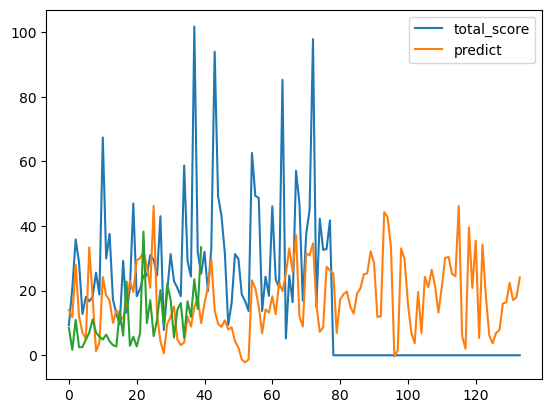

In [48]:
y_validate.drop(columns='index').plot()
y_train.plot()

<AxesSubplot:>

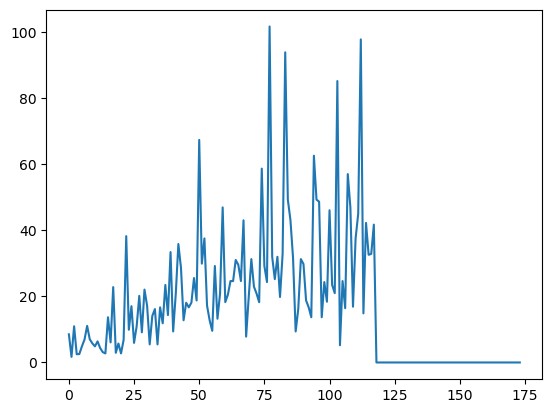

In [49]:
seinfeld.total_score.plot()

In [50]:
seinfeld_prepped.airdate = pd.to_datetime(seinfeld_prepped.airdate)
x=seinfeld_prepped.drop(columns=['plot','quotability','laughs','total_score']).set_index('airdate')
x_train = seinfeld_prepped.drop(columns=['plot','quotability','laughs','total_score'])[seinfeld_prepped.total_score > 0].set_index('airdate')
y_train = seinfeld_prepped.total_score[seinfeld_prepped.total_score > 0]
regr = MLPRegressor( max_iter=150,solver= 'lbfgs').fit(x_train,y_train)
mlp_predictions=pd.DataFrame(regr.predict(x),columns=['predict'])
y_mlp=pd.concat([y_train,mlp_predictions],axis=1)

<AxesSubplot:>

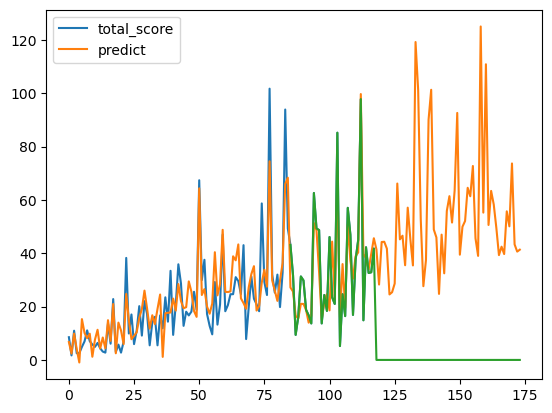

In [51]:
y_mlp.plot()
seinfeld[seinfeld.season_y > 5].total_score.plot()


In [52]:
seinfeld_prepped.corr()

,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,season_y,episodeno,"writers_Alec Berg, Jeff Schaffer","writers_Alec Berg, Jeff Schaffer, David Mandel",...,"writers_Tom Gammill, Max Pross","writers_Tom Gammill, Max Pross and Larry David","writers_Tom Gammill, Max Pross and Larry David, Jerry Seinfeld",writers_Tom Leopold,director_Art Wolff,director_David Owen Trainor,director_David Steinberg,director_Jason Alexander,director_Joshua White,director_Tom Cherones
plot,1.000000,0.434016,0.364254,0.575531,0.414206,-0.408395,0.188291,-0.095404,-0.064656,NaN,...,-0.078209,0.150290,-0.092645,-0.045323,0.028823,-0.092645,-0.045323,-0.092645,-0.092645,-0.000404
quotability,0.434016,1.000000,0.575676,0.690667,0.445074,-0.424210,0.523403,0.218312,0.032920,NaN,...,0.110693,0.090946,0.041147,-0.153745,-0.008651,-0.058450,-0.153745,-0.008651,-0.008651,-0.169973
laughs,0.364254,0.575676,1.000000,0.915000,0.576703,-0.529498,0.620292,0.249548,0.105111,NaN,...,0.002235,0.135478,0.195370,-0.119488,-0.114075,-0.009263,-0.108855,-0.054183,-0.109084,-0.267772
total_score,0.575531,0.690667,0.915000,1.000000,0.372635,-0.302386,-0.199294,0.010098,-0.045535,-0.090840,...,0.072155,0.178427,0.012736,-0.048569,-0.031044,-0.053226,-0.035971,-0.018079,-0.037527,0.230212
imdb_rating,0.414206,0.445074,0.576703,0.372635,1.000000,-0.956025,0.225811,0.165351,0.045695,0.021098,...,-0.023232,0.106660,-0.003481,-0.096063,-0.131979,-0.004938,-0.017956,-0.058552,0.051589,-0.106283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
director_David Owen Trainor,-0.092645,-0.058450,-0.009263,-0.053226,-0.004938,-0.001307,0.069013,-0.003760,-0.025184,-0.011628,...,-0.026627,-0.008198,-0.008198,-0.011628,-0.008198,1.000000,-0.011628,-0.008198,-0.008198,-0.099479
director_David Steinberg,-0.045323,-0.153745,-0.108855,-0.035971,-0.017956,0.021429,-0.120094,-0.099506,-0.025184,-0.011628,...,-0.026627,-0.008198,-0.008198,-0.011628,-0.008198,-0.011628,1.000000,-0.008198,-0.008198,-0.099479
director_Jason Alexander,-0.092645,-0.008651,-0.054183,-0.018079,-0.058552,0.082283,-0.084674,0.098609,-0.017756,-0.008198,...,-0.018774,-0.005780,-0.005780,-0.008198,-0.005780,-0.008198,-0.008198,1.000000,-0.005780,-0.070139
director_Joshua White,-0.092645,-0.008651,-0.109084,-0.037527,0.051589,-0.070385,-0.084674,-0.070158,-0.017756,-0.008198,...,-0.018774,-0.005780,-0.005780,-0.008198,-0.005780,-0.008198,-0.008198,-0.005780,1.000000,-0.070139


In [53]:
scripts['line']=scripts.Character.str.strip() +': ' + scripts.Dialogue.str.strip()

In [54]:
scripts.SEID.unique().tolist()

['S01E01',
 'S01E02',
 'S01E03',
 'S01E04',
 'S02E01',
 'S02E02',
 'S02E03',
 'S02E04',
 'S02E05',
 'S02E06',
 'S02E07',
 'S02E08',
 'S02E09',
 'S02E10',
 'S02E11',
 'S02E12',
 'S03E01',
 'S03E02',
 'S03E03',
 'S03E04',
 'S03E05',
 'S03E06',
 'S03E07',
 'S03E08',
 'S03E09',
 'S03E10',
 'S03E11',
 'S03E12',
 'S03E13',
 'S03E14',
 'S03E15',
 'S03E16',
 'S03E17',
 'S03E18',
 'S03E19',
 'S03E20',
 'S03E21',
 'S03E22',
 'S03E23',
 'S04E01',
 'S04E02',
 'S04E03',
 'S04E04',
 'S04E05',
 'S04E06',
 'S04E07',
 'S04E08',
 'S04E09',
 'S04E10',
 'S04E11',
 'S04E12',
 'S04E13',
 'S04E14',
 'S04E15',
 'S04E16',
 'S04E17',
 'S04E18',
 'S04E19',
 'S04E20',
 'S04E21',
 'S04E22',
 'S04E23',
 'S04E24',
 'S05E01',
 'S05E02',
 'S05E03',
 'S05E04',
 'S05E05',
 'S05E06',
 'S05E07',
 'S05E08',
 'S05E09',
 'S05E10',
 'S05E11',
 'S05E12',
 'S05E13',
 'S05E14',
 'S05E15',
 'S05E16',
 'S05E17',
 'S05E18',
 'S05E20',
 'S05E21',
 'S05E22',
 'S06E01',
 'S06E02',
 'S06E03',
 'S06E04',
 'S06E05',
 'S06E06',
 'S06E07',

In [55]:
seinfeld.seid.unique().tolist()

['S01E00',
 'S01E03',
 'S01E01',
 'S01E02',
 'S01E04',
 'S02E01',
 'S02E02',
 'S02E03',
 'S02E04',
 'S02E05',
 'S02E06',
 'S02E07',
 'S02E08',
 'S02E09',
 'S02E10',
 'S02E11',
 'S02E12',
 'S03E01',
 'S03E02',
 'S03E03',
 'S03E04',
 'S03E05',
 'S03E06',
 'S03E07',
 'S03E08',
 'S03E09',
 'S03E10',
 'S03E11',
 'S03E12',
 'S03E13',
 'S03E14',
 'S03E15',
 'S03E16',
 'S03E17',
 'S03E18',
 'S03E19',
 'S03E20',
 'S03E21',
 'S03E22',
 'S03E23',
 'S04E01',
 'S04E02',
 'S04E03',
 'S04E04',
 'S04E05',
 'S04E06',
 'S04E07',
 'S04E08',
 'S04E09',
 'S04E10',
 'S04E11',
 'S04E12',
 'S04E13',
 'S04E14',
 'S04E15',
 'S04E16',
 'S04E17',
 'S04E18',
 'S04E19',
 'S04E20',
 'S04E21',
 'S04E22',
 'S04E23',
 'S04E24',
 'S05E01',
 'S05E02',
 'S05E03',
 'S05E04',
 'S05E05',
 'S05E06',
 'S05E07',
 'S05E08',
 'S05E09',
 'S05E10',
 'S05E11',
 'S05E12',
 'S05E13',
 'S05E14',
 'S05E15',
 'S05E16',
 'S05E17',
 'S05E18',
 'S05E20',
 'S05E21',
 'S05E22',
 'S06E01',
 'S06E02',
 'S06E03',
 'S06E04',
 'S06E05',
 'S06E06',

In [56]:
ss = pd.read_csv('seinfeld_scripts.csv')
ss = pd.DataFrame(ss)
ss = ss.drop(columns=['Unnamed: 0'])
ss

,script
0,'JERRY: Do you know what this is all about? Do...
1,"'JERRY: So, Im on line at the supermarket. Two..."
2,"'JERRY: So I move into the centre lane, now I ..."
3,'JERRY: Most men like working on things. Tools...
4,'JERRY: Went out to dinner the other night. Ch...
...,...
169,'GEORGE: I read somewhere that this Brentano's...
170,'ALL: Happy birthday to you.\n ...
171,'JERRY: Cup of tea with lemon.\n ...
172,"'GEORGE: Man, I'm starving.\n ELAINE: How c..."


In [57]:
seinfeld['script'] = ss
seinfeld.script = seinfeld.script.astype(str)

In [58]:
seinfeld.script = seinfeld.script.str.replace(r"(S\d+E\d+|,\s\d*\s{2,}|Name:.*)|\(\'|(?<=\n)\d+","")

In [59]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid,script
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0,1.0,0.0,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,'JERRY: Do you know what this is all about? Do...
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0,1.0,3.0,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03,"'JERRY: So, Im on line at the supermarket. Two..."
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0,1.0,1.0,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,"'JERRY: So I move into the centre lane, now I ..."
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0,1.0,2.0,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02,'JERRY: Most men like working on things. Tools...
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0,1.0,4.0,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04,'JERRY: Went out to dinner the other night. Ch...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,the_bookstore,NaN,NaN,NaN,0.000000,8.2,98.0,NaN,9.0,17.0,9.0,17.0,"April 9, 1998",Spike Feresten,Andy Ackerman,S09E17,'GEORGE: I read somewhere that this Brentano's...
170,the_frogger,NaN,NaN,NaN,0.000000,8.7,24.0,NaN,9.0,18.0,9.0,18.0,"April 23, 1998","Gregg Kavet, Andy Robin",Andy Ackerman,S09E18,'ALL: Happy birthday to you.\n ...
171,the_maid,NaN,NaN,NaN,0.000000,8.0,135.0,NaN,9.0,19.0,9.0,19.0,"April 30, 1998","Alec Berg, David Mandel, Jeff Schaffer",Andy Ackerman,S09E19,'JERRY: Cup of tea with lemon.\n ...
172,the_puerto_rican_day,NaN,NaN,NaN,0.000000,7.9,149.0,NaN,9.0,20.0,9.0,20.0,"May 7, 1998","Alec Berg, Jennifer Crittenden, Spike Feresten...",Andy Ackerman,S09E20,"'GEORGE: Man, I'm starving.\n ELAINE: How c..."


In [60]:
class lemmatizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, df):
        return [self.wnl.lemmatize(word) for word in word_tokenize(df)]

vectorizer = CountVectorizer( max_df=0.95, min_df=0.05, ngram_range=(1,2),
                             tokenizer=lemmatizer(), lowercase=True, stop_words='english',
                             token_pattern = r'\w+')

vectorizer.fit(seinfeld['script'])
count_vector = vectorizer.transform(seinfeld['script'])

bow_data = count_vector.toarray()
bow_data = pd.DataFrame(bow_data, columns=vectorizer.get_feature_names_out())
bow_data.head()

,!,! !,! (,! ...,! george,! jerry,','d,'elaine,'elaine :,...,woman,y,y ...,ya,yeah,"yeah ,",yeah .,yes,yo,yo ...
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,3,2,1,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid,script
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0,1.0,0.0,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,'JERRY: Do you know what this is all about? Do...
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0,1.0,3.0,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03,"'JERRY: So, Im on line at the supermarket. Two..."
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0,1.0,1.0,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,"'JERRY: So I move into the centre lane, now I ..."
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0,1.0,2.0,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02,'JERRY: Most men like working on things. Tools...
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0,1.0,4.0,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04,'JERRY: Went out to dinner the other night. Ch...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,the_bookstore,NaN,NaN,NaN,0.000000,8.2,98.0,NaN,9.0,17.0,9.0,17.0,"April 9, 1998",Spike Feresten,Andy Ackerman,S09E17,'GEORGE: I read somewhere that this Brentano's...
170,the_frogger,NaN,NaN,NaN,0.000000,8.7,24.0,NaN,9.0,18.0,9.0,18.0,"April 23, 1998","Gregg Kavet, Andy Robin",Andy Ackerman,S09E18,'ALL: Happy birthday to you.\n ...
171,the_maid,NaN,NaN,NaN,0.000000,8.0,135.0,NaN,9.0,19.0,9.0,19.0,"April 30, 1998","Alec Berg, David Mandel, Jeff Schaffer",Andy Ackerman,S09E19,'JERRY: Cup of tea with lemon.\n ...
172,the_puerto_rican_day,NaN,NaN,NaN,0.000000,7.9,149.0,NaN,9.0,20.0,9.0,20.0,"May 7, 1998","Alec Berg, Jennifer Crittenden, Spike Feresten...",Andy Ackerman,S09E20,"'GEORGE: Man, I'm starving.\n ELAINE: How c..."


In [62]:
x_train, x_test, y_train, y_test = train_test_split(bow_data,
                                                  seinfeld['total_score'],
                                                  test_size=0.2, random_state=123)

In [63]:
train=seinfeld[seinfeld.season_x<6].total_score

In [64]:
regr = MLPRegressor( max_iter=5000,solver= 'lbfgs').fit(bow_data[:85],train)
mlp_predictions=pd.DataFrame(regr.predict(bow_data),columns=['predict'])
y_mlp=pd.concat([train,mlp_predictions],axis=1)

<AxesSubplot:>

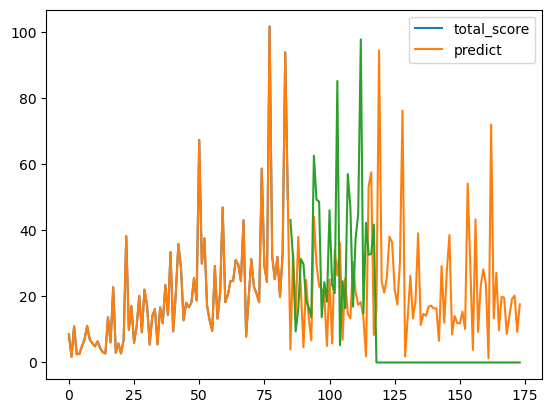

In [65]:
y_mlp.plot()
seinfeld[seinfeld.season_y > 5].total_score.plot()

In [66]:
total_score=seinfeld.total_score[seinfeld.total_score>0]

In [69]:
mse = mean_squared_error(total_score,y_mlp.predict[:118])
rmse = mse**.5
rmse

14.404562112115999

In [70]:
#y_mlp.total_score = y_mlp.total_score.replace(np.NaN, 0)

In [71]:
y_mlp.total_score.isna().sum()

89

<AxesSubplot:>

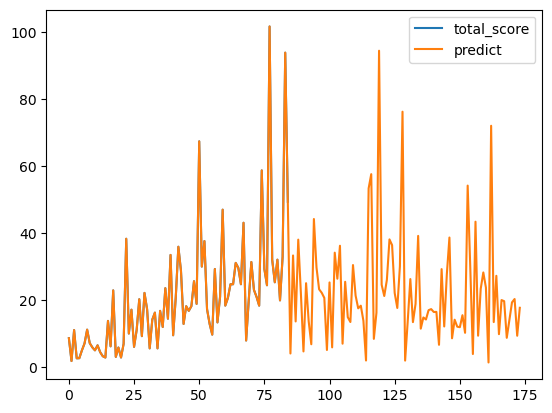

In [72]:
y_mlp.plot()

In [73]:
y_mlp.head(50)

,total_score,predict
0,8.521739,8.521911
1,1.695652,1.695410
2,10.956522,10.956590
3,2.510870,2.509634
4,2.543478,2.544570
5,4.891304,4.891706
6,6.956522,6.955494
7,11.086957,11.087044
8,7.043478,7.044078
9,5.782609,5.782254


In [74]:
seinfeld.script.to_csv('seinfeld_scripts.csv')

In [75]:
scripts

,Character,Dialogue,EpisodeNo,SEID,Season,line
0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0,JERRY: Do you know what this is all about? Do ...
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0,"JERRY: (pointing at Georges shirt) See, to me,..."
2,GEORGE,Are you through?,1.0,S01E01,1.0,GEORGE: Are you through?
3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0,"JERRY: You do of course try on, when you buy?"
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0,"GEORGE: Yes, it was purple, I liked it, I dont..."
...,...,...,...,...,...,...
54611,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,S09E23,9.0,JERRY: Grand theft auto - don't steal any of m...
54612,PRISONER 3,You suck - I'm gonna cut you.,23.0,S09E23,9.0,PRISONER 3: You suck - I'm gonna cut you.
54613,JERRY,"Hey, I don't come down to where you work, and ...",23.0,S09E23,9.0,"JERRY: Hey, I don't come down to where you wor..."
54614,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,S09E23,9.0,"GUARD: Alright, Seinfeld, that's it. Let's go...."


In [76]:
seinfeld[seinfeld.total_score>40]

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid,script
50,the_contest,5.0,10.0,31.0,67.391304,9.6,1.0,first appearance of Estelle.,4.0,11.0,4.0,11.0,"November 18, 1992",Larry David,Tom Cherones,S04E11,'JERRY: (To Elaine) Let me ask you a question....
59,the_junior_mint,4.0,10.0,27.0,46.956522,8.7,24.0,"""DOLORES!!!""",4.0,20.0,4.0,20.0,"March 18, 1993",Andy Robin,Tom Cherones,S04E20,'JERRY: You can't just *have* an adultery-- yo...
67,the_sniffing_accountant,4.0,9.0,27.5,43.043478,8.0,135.0,"""heres to feeling good all the time""",5.0,4.0,5.0,4.0,"October 7, 1993","Larry David, Jerry Seinfeld",Tom Cherones,S05E04,"'JERRY: So, does he like you?\n ..."
74,the_conversion,5.0,9.0,30.0,58.695652,8.1,112.0,NaN,5.0,11.0,5.0,11.0,"December 16, 1993",Bruce Kirschbaum,Tom Cherones,S05E11,'JERRY: You know doctor is supposed to be such...
77,the_marine_biologist,5.0,9.0,52.0,101.739130,9.2,5.0,NaN,5.0,14.0,5.0,14.0,"February 10, 1994","Ron Hague, Charlie Rubin",Tom Cherones,S05E14,"'JERRY: I love these nature shows, Ill watch a..."
83,the_hamptons,5.0,9.0,48.0,93.913043,8.9,10.0,"""Shrinkage""",5.0,20.0,5.0,21.0,"May 12, 1994","Peter Mehlman, Carol Leifer",Tom Cherones,S05E21,"'KRAMER: All right, get off at the next exit.\..."
84,the_opposite,4.0,9.0,31.5,49.304348,9.6,1.0,NaN,5.0,21.0,5.0,22.0,"May 19, 1994","Andy Cowan and Larry David, Jerry Seinfeld",Tom Cherones,S05E22,'MR. LIPPMAN: To your promotion.\n ELAINE: ...
85,the_chaperone,4.0,8.0,31.0,43.130435,7.9,149.0,"first ""that's a shame""",6.0,1.0,6.0,1.0,"September 22, 1994","Larry David, Bill Masters, Bob Shaw",Andy Ackerman,S06E01,"'GEORGE: O.K., Danny, take a swing. (Tartabull..."
94,the_race,5.0,9.0,32.0,62.608696,8.9,10.0,NaN,6.0,10.0,6.0,10.0,"December 15, 1994","Tom Gammill, Max Pross and Larry David",Andy Ackerman,S06E10,'JERRY: Ready to go Lois?\n LOIS: You real...
95,the_switch,4.0,9.0,31.5,49.304348,8.9,10.0,"""Kramer's first name revealed""",6.0,11.0,6.0,11.0,"January 5, 1995",Bruce Kirschbaum and Sam Kass,Andy Ackerman,S06E11,"'JERRY: Come on. Lets go\n ELAINE: No wait,..."


In [77]:
headers = {'User-Agent': 'Codeup Data Science'} # Some websites don't accept the pyhon-requests default user-agent
url = f'https://seinfeld.fandom.com/wiki/List_of_Seinfeld_episodes'
response = get(url, headers=headers)
soup = bs(response.content, 'html.parser')
tables = soup.find_all('table')
tables

[<table class="wikitable" width="100%">
 <tbody><tr>
 <th>#
 </th>
 <th>
 </th>
 <th>Title
 </th>
 <th><a href="/wiki/Category:Directors" title="Category:Directors">Directed By</a><br/><a href="/wiki/Category:Writers" title="Category:Writers">Written By</a>
 </th>
 <th>Air Date
 </th></tr>
 <tr>
 <td rowspan="2">1</td>
 <td rowspan="2"><a href="/wiki/The_Seinfeld_Chronicles" title="The Seinfeld Chronicles"><img alt="The Seinfeld Chronicles.jpg" data-image-key="The_Seinfeld_Chronicles.jpg" data-image-name="The Seinfeld Chronicles.jpg" decoding="async" height="94" loading="lazy" src="https://static.wikia.nocookie.net/seinfeld/images/9/9c/The_Seinfeld_Chronicles.jpg/revision/latest/scale-to-width-down/125?cb=20080801224556" width="125"/></a></td>
 <td><b>"<a href="/wiki/The_Seinfeld_Chronicles" title="The Seinfeld Chronicles">The Seinfeld Chronicles</a>"</b></td>
 <td><a href="/wiki/Art_Wolff" title="Art Wolff">Art Wolff</a><br/><a href="/wiki/Larry_David" title="Larry David">Larry David<

In [78]:
rows = []

# Find all `tr` tags
for table in tables[:-1]:
    data_rows = table.find_all('tr')
    for row in data_rows:
        value = row.find_all('td')
        beautified_value = [ele.text.strip() for ele in value]
        # Remove data arrays that are empty
        if len(beautified_value) == 0:
            continue
        rows.append(beautified_value)
rows = rows[1::2]

In [79]:
rows.insert(38,"Coming from an outing to a flea market in Westchester, Elaine and George damage Jerry's car when George drives over a large pothole. When they get to his apartment they conveniently find a parking space right in front of Jerry's building. As George tries to back in however, someone tries to take the spot by driving in nose-first. Neither car is able to park, and an all-day argument ensues.. Meanwhile, Elaine must come up with a story about the damage to the car.")

In [80]:
seinfeld['synopsis']=rows

In [81]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid,script,synopsis
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0,1.0,0.0,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,'JERRY: Do you know what this is all about? Do...,[When Jerry gets a phone call from a woman he ...
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0,1.0,3.0,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03,"'JERRY: So, Im on line at the supermarket. Two...",[Jerry meets a woman at a party but only finds...
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0,1.0,1.0,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,"'JERRY: So I move into the centre lane, now I ...",[Jerry is robbed after Kramer leaves the door ...
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0,1.0,2.0,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02,'JERRY: Most men like working on things. Tools...,[Jerry tries to end a friendship with a childh...
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0,1.0,4.0,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04,'JERRY: Went out to dinner the other night. Ch...,[George gets a stellar stock tip which he advi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,the_bookstore,NaN,NaN,NaN,0.000000,8.2,98.0,NaN,9.0,17.0,9.0,17.0,"April 9, 1998",Spike Feresten,Andy Ackerman,S09E17,'GEORGE: I read somewhere that this Brentano's...,[After a childhood pizzeria goes out of busine...
170,the_frogger,NaN,NaN,NaN,0.000000,8.7,24.0,NaN,9.0,18.0,9.0,18.0,"April 23, 1998","Gregg Kavet, Andy Robin",Andy Ackerman,S09E18,'ALL: Happy birthday to you.\n ...,[Jerry hires a maid who he then starts sleepin...
171,the_maid,NaN,NaN,NaN,0.000000,8.0,135.0,NaN,9.0,19.0,9.0,19.0,"April 30, 1998","Alec Berg, David Mandel, Jeff Schaffer",Andy Ackerman,S09E19,'JERRY: Cup of tea with lemon.\n ...,[The gang leaves a New York Mets game early in...
172,the_puerto_rican_day,NaN,NaN,NaN,0.000000,7.9,149.0,NaN,9.0,20.0,9.0,20.0,"May 7, 1998","Alec Berg, Jennifer Crittenden, Spike Feresten...",Andy Ackerman,S09E20,"'GEORGE: Man, I'm starving.\n ELAINE: How c...",[A retrospective on the past 9 years of Seinfe...


In [82]:
characters = scripts.Character.unique().tolist()
mains = ['JERRY','GEORGE','KRAMER','KESSLER','ELAINE']

<AxesSubplot:xlabel='total_score', ylabel='director'>

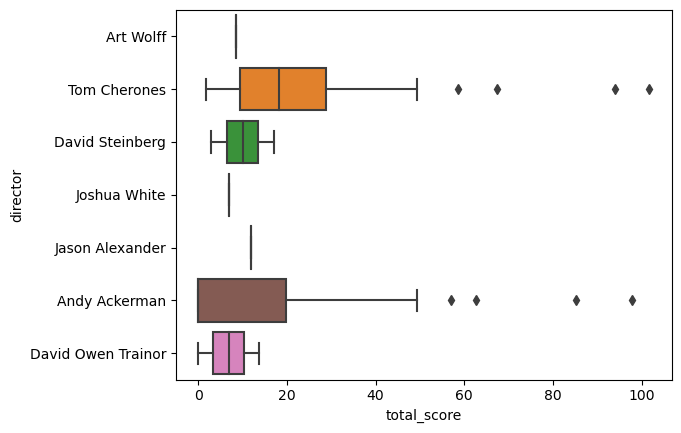

In [86]:
sns.boxplot(data=seinfeld,x='total_score',y='director')